In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from scipy.optimize import curve_fit

plt.style.use("science")

In [21]:
unit_length = 100/1000

Dose at 1 m

In [77]:
dose_to_volume = np.array([np.genfromtxt(f'./outputs/phantom_DoseScore_{i}.csv', delimiter=',') for i in range(1,6)])
doses = np.array([np.genfromtxt(f'./outputs/fixed_DoseScore_{i}.csv', delimiter=',')[:, -1] for i in range(1,6)])
doses = np.array([dose/dose_to_volume[i] for i, dose in enumerate(doses)])

In [78]:
dose_to_volume

array([2.79129636e-11, 2.93769176e-11, 2.75887126e-11, 2.91396247e-11,
       2.90570814e-11])

In [81]:
mean_doses = np.mean(doses, axis=0)
filt = np.where(np.mean(doses, axis=0) > 0)
mean_doses = mean_doses[filt]
std_doses = np.std(doses, axis=0)[filt]

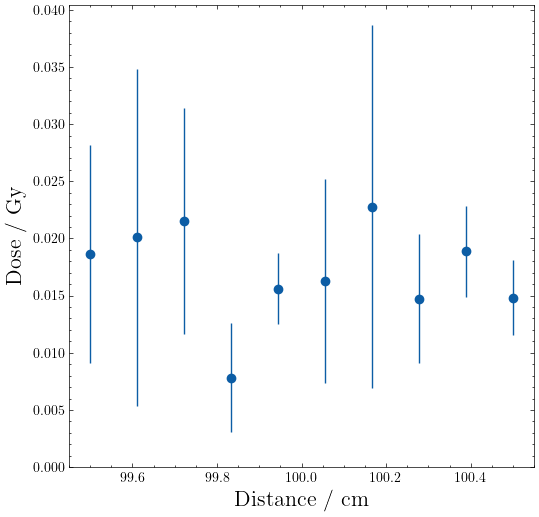

In [96]:
plt.figure(figsize=(6,6))

plt.errorbar(
    x=[i for i in np.linspace(99.5, 100.5, 10)],
    y=mean_doses,
    yerr=std_doses,
    marker="o",
    ls="None"
)
plt.ylim(0, )
plt.xlabel("Distance / cm", fontsize=16)
plt.ylabel("Dose / Gy", fontsize=16)
plt.savefig("./plots/dose_dist.png", dpi=300)

In [93]:
np.mean(mean_doses), np.mean(std_doses)

(0.01710989543326201, 0.007962190177954274)

In [47]:
np.mean(doses[:, -1]), np.std(doses[:, -1])

(6.5331731635171235e-06, 6.974559526605928e-06)

In [48]:
mean_doses[-1]/1e-3, std_doses[-1]/1e-3

(0.006533173163517123, 0.006974559526605927)

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_37568/1475031241.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f"./outputs/SurfaceScore_{i}.phsp", delim_whitespace=True, names=columns)
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_37568/1475031241.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f"./outputs/SurfaceScore_{i}.phsp", delim_whitespace=True, names=columns)
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_37568/1475031241.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f"./outputs/SurfaceScore_{i}.phsp", delim_whitespace=True, names=columns)
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn

The RBE is: 7.557420494699647
The RBE is: 7.464962901896125
The RBE is: 7.415397631133672
The RBE is: 7.392384105960264
The RBE is: 7.022058823529411


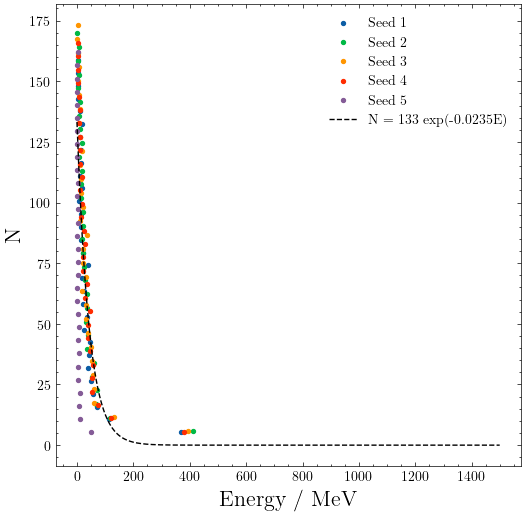

In [103]:
columns = [ "Position X [cm]", "Position Y [cm]", "Position Z [cm]",
"Direction Cosine X", "Direction Cosine Y", "Energy [MeV]", "Weight", "Particle Type (in PDG Format)",
"Flag to tell if Third Direction Cosine is Negative (1 means true)", "Flag to tell if this is the First Scored Particle from this History (1 means true)"]

RBES = []
energies = []
counts = []

plt.figure(figsize=(6,6))
for i in range(1, 6):
    df = pd.read_csv(f"./outputs/SurfaceScore_{i}.phsp", delim_whitespace=True, names=columns)
    neutron_df = df[df["Particle Type (in PDG Format)"] == 2112]
    neutron_df_filtered = neutron_df[neutron_df["Energy [MeV]"] > 1e-6]
    x = np.histogram(
        neutron_df_filtered["Energy [MeV]"], bins=30
    )
    
    energies.append(x[0])
    counts.append(x[1][1::])
    
    plt.scatter(
        x[0],
        x[1][1::],
        s=8,
        label=f"Seed {i}"
    )
    
    bin1 = neutron_df_filtered[neutron_df_filtered["Energy [MeV]"] < 10e-2]
    bin2 = neutron_df_filtered[(neutron_df_filtered["Energy [MeV]"] >= 10e-2) & (neutron_df_filtered["Energy [MeV]"] < 10e-1)]
    bin3 = neutron_df_filtered[(neutron_df_filtered["Energy [MeV]"] >= 10e-1) & (neutron_df_filtered["Energy [MeV]"] < 2)]
    bin4 = neutron_df_filtered[(neutron_df_filtered["Energy [MeV]"] >= 2) & (neutron_df_filtered["Energy [MeV]"] < 20)]
    bin5 = neutron_df_filtered[(neutron_df_filtered["Energy [MeV]"] >= 20)]

    RBE = (len(bin1)/len(neutron_df_filtered)) * 5 + (len(bin2)/len(neutron_df_filtered))*10 + (len(bin3)/len(neutron_df_filtered))*20 + (len(bin4)/len(neutron_df_filtered))*10 + (len(bin5)/len(neutron_df_filtered))*5
    RBES.append(RBE)

    print(f"The RBE is: {RBE}")

plt.xlabel("Energy / MeV", fontsize=16)
plt.ylabel("N", fontsize=16)
# Fit a power law to this.

def f(x, N0, a):
    return N0 *np.exp(-a*x)

N0, a = curve_fit(f, xdata=np.array(energies).flatten(), ydata=np.array(counts).flatten())[0]

plt.plot(
    [E for E in range(1500)],
    f(np.array([E for E in range(1500)]), N0, a),
    label=f"N = 133 exp(-0.0235E)",
    color="black",
    ls="--"
)
plt.legend()
plt.savefig("./plots/energy_distribution.png", dpi=300)


In [104]:
np.mean(RBES), np.std(RBES)

(7.370444791443823, 0.18317666923971385)

In [6]:
# 2112 = Neutron code